# Supervised learning post-processing of CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this fourth notebook is to apply Supervised Learning to improve the quality CTscan imaging. We will be using a training dataset composed of several brain images and their corresponding FBP results for a CT aquisition with poor angle coverage. We wish to train a network to transform the FBP images into those of higher quality (assumed to be obtained using a a CT aquisition with better angle coverage). 

The problem that we wish to solve can be expressed as:

$$
\underset{\theta} {\mathrm{argmin}} \; \Vert \mathbf{x}- f_\theta(\mathbf{x}_{FBP}) \Vert_2^2
$$

where $f_\theta$ is the network.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch
import torch.nn as nn

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from pylops import TorchOperator
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from plotting import plt_comparison
from suptrain import *
from unet2d import ResUNet

#device = 'cpu'
device = torch.device('cuda:0')
trainnet = True # True: run training, False: load pre-trained network

## Load training dataset

In [2]:
# Load data
f = np.load('../data/brains_fbp_trainingdata.npz')
brains = f['brains']
brainsfbp = f['fbps']
nx, ny = brains.shape[1:]

# Remove 10th element, always used to test different imaging algorithm
brain_test = brains[10]
brainfbp_test = brainsfbp[10]
brains = np.delete(brains, 10, axis=0)
brainsfbp = np.delete(brainsfbp, 10, axis=0)

In [3]:
iimages = np.random.randint(0, len(brains), 4)
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 16))

for iax, iimage in enumerate(iimages):
    axs[iax, 0].imshow(brains[iimage], cmap="bone")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(brainsfbp[iimage], cmap="bone")
    axs[iax, 1].axis("off")
    axs[iax, 2].imshow(brains[iimage+1], cmap="bone")
    axs[iax, 2].axis("off")
    axs[iax, 3].imshow(brainsfbp[iimage+1], cmap="bone")
    axs[iax, 3].axis("off")
plt.tight_layout()

In [4]:
# Create train/validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(brainsfbp, brains, 
                                                      test_size=0.2, random_state=42)

In [5]:
# Convert Train Set to Torch
X_train = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train = torch.from_numpy(Y_train).float().unsqueeze(1)
train_dataset = TensorDataset(X_train, Y_train)

# Define Valid Set to Torch
X_valid = torch.from_numpy(X_valid).float().unsqueeze(1)
Y_valid = torch.from_numpy(Y_valid).float().unsqueeze(1)
valid_dataset = TensorDataset(X_valid, Y_valid)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
network = ResUNet(1, 1, hidden_channels=8, levels=2, subsampling=[[2,  2], [2, 2]]).to(device)
network = network.apply(network.weights_init) 
summary(network, input_size=(1, 1, nx, ny))

Layer (type:depth-idx)                             Output Shape              Param #
ResUNet                                            [1, 1, 256, 256]          --
├─ResNetBlock: 1-1                                 [1, 8, 256, 256]          --
│    └─Sequential: 2-1                             [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-1                            [1, 8, 256, 256]          8
│    │    └─BatchNorm2d: 3-2                       [1, 8, 256, 256]          16
│    └─Sequential: 2-2                             [1, 8, 256, 256]          --
│    │    └─Sequential: 3-3                        [1, 8, 256, 256]          88
│    │    └─Sequential: 3-4                        [1, 8, 256, 256]          592
│    └─LeakyReLU: 2-3                              [1, 8, 256, 256]          --
│    └─BatchNorm2d: 2-4                            [1, 8, 256, 256]          16
├─Sequential: 1-2                                  --                        --
│    └─ContractingBlock_Res: 2-5   

In [7]:
if trainnet:
    n_epochs = 30
    lr = 1e-3

    criterion = nn.MSELoss()
    optim = torch.optim.Adam(network.parameters(), lr=lr)

    train_loss_history = np.zeros(n_epochs)
    valid_loss_history = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        train_loss = train(network, criterion, optim, 
                           train_loader, device=device)
        valid_loss = evaluate(network, criterion, 
                              valid_loader, device=device)
        train_loss_history[epoch] = train_loss
        valid_loss_history[epoch] = valid_loss
        
        print(f'Epoch {epoch}, Training Loss {train_loss:.4f}, Valid Loss {valid_loss:.4f}')

    # Save model
    torch.save(network.state_dict(), '../models/Supervised.pt')

else:   
    # Load model
    network.load_state_dict(torch.load('../models/Supervised.pt'))    

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, Training Loss 0.0278, Valid Loss 0.0283


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1, Training Loss 0.0234, Valid Loss 0.0266


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2, Training Loss 0.0176, Valid Loss 0.0261


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3, Training Loss 0.0117, Valid Loss 0.0255


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4, Training Loss 0.0059, Valid Loss 0.0183


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5, Training Loss 0.0023, Valid Loss 0.0039


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.0011, Valid Loss 0.0017


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.0009, Valid Loss 0.0009


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.0008, Valid Loss 0.0013


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.0009, Valid Loss 0.0009


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.0008, Valid Loss 0.0009


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.0008, Valid Loss 0.0009


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.0008, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.0008, Valid Loss 0.0008


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.0008, Valid Loss 0.0008


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.0008, Valid Loss 0.0008


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.0008, Valid Loss 0.0008


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.0007, Valid Loss 0.0008


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.0007, Valid Loss 0.0008


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.0008, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.0007, Valid Loss 0.0008


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.0007, Valid Loss 0.0007


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.0007, Valid Loss 0.0007


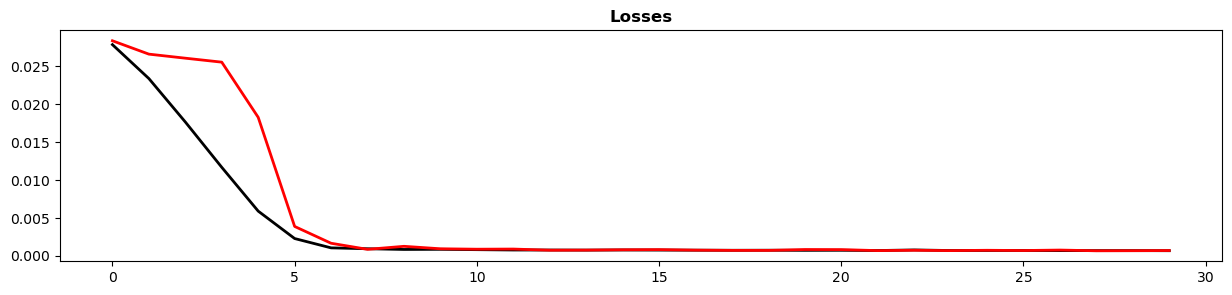

In [8]:
if trainnet:
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.plot(train_loss_history, 'k', lw=2, label='Train')
    ax.plot(valid_loss_history, 'r', lw=2, label='Valid')
    ax.set_title('Losses', fontweight='bold');

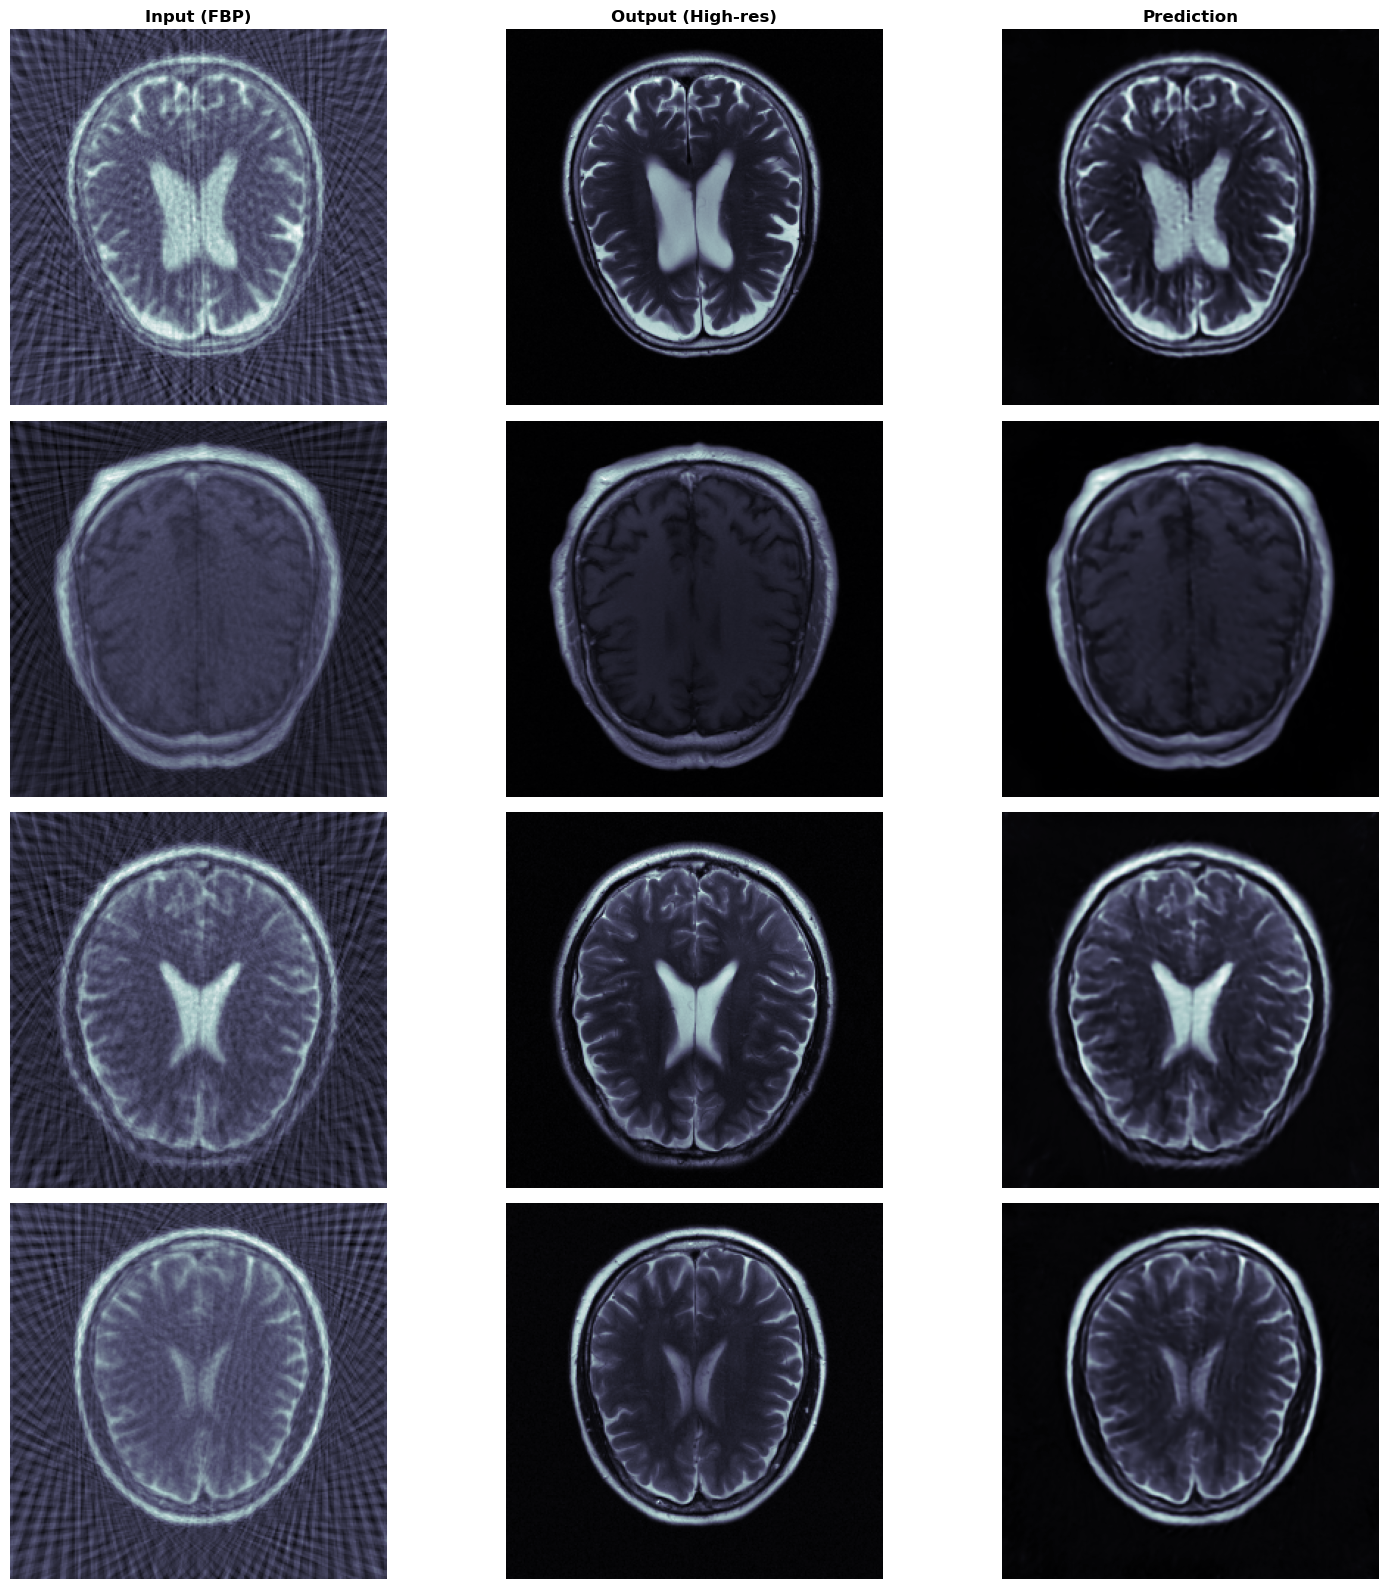

In [9]:
# Training predictions
Y_train_pred = network(X_train[:4].to(device))

fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(16, 16))

for iax, iimage in enumerate(range(4)):
    axs[iax, 0].imshow(X_train[iimage].squeeze(), cmap="bone")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(Y_train[iimage].squeeze(), cmap="bone")
    axs[iax, 1].axis("off")
    axs[iax, 2].imshow(Y_train_pred[iimage].cpu().detach().numpy().squeeze(), cmap="bone")
    axs[iax, 2].axis("off")
axs[0, 0].set_title("Input (FBP)", fontweight="bold")
axs[0, 1].set_title("Output (High-res)", fontweight="bold")
axs[0, 2].set_title("Prediction", fontweight="bold")

plt.tight_layout()

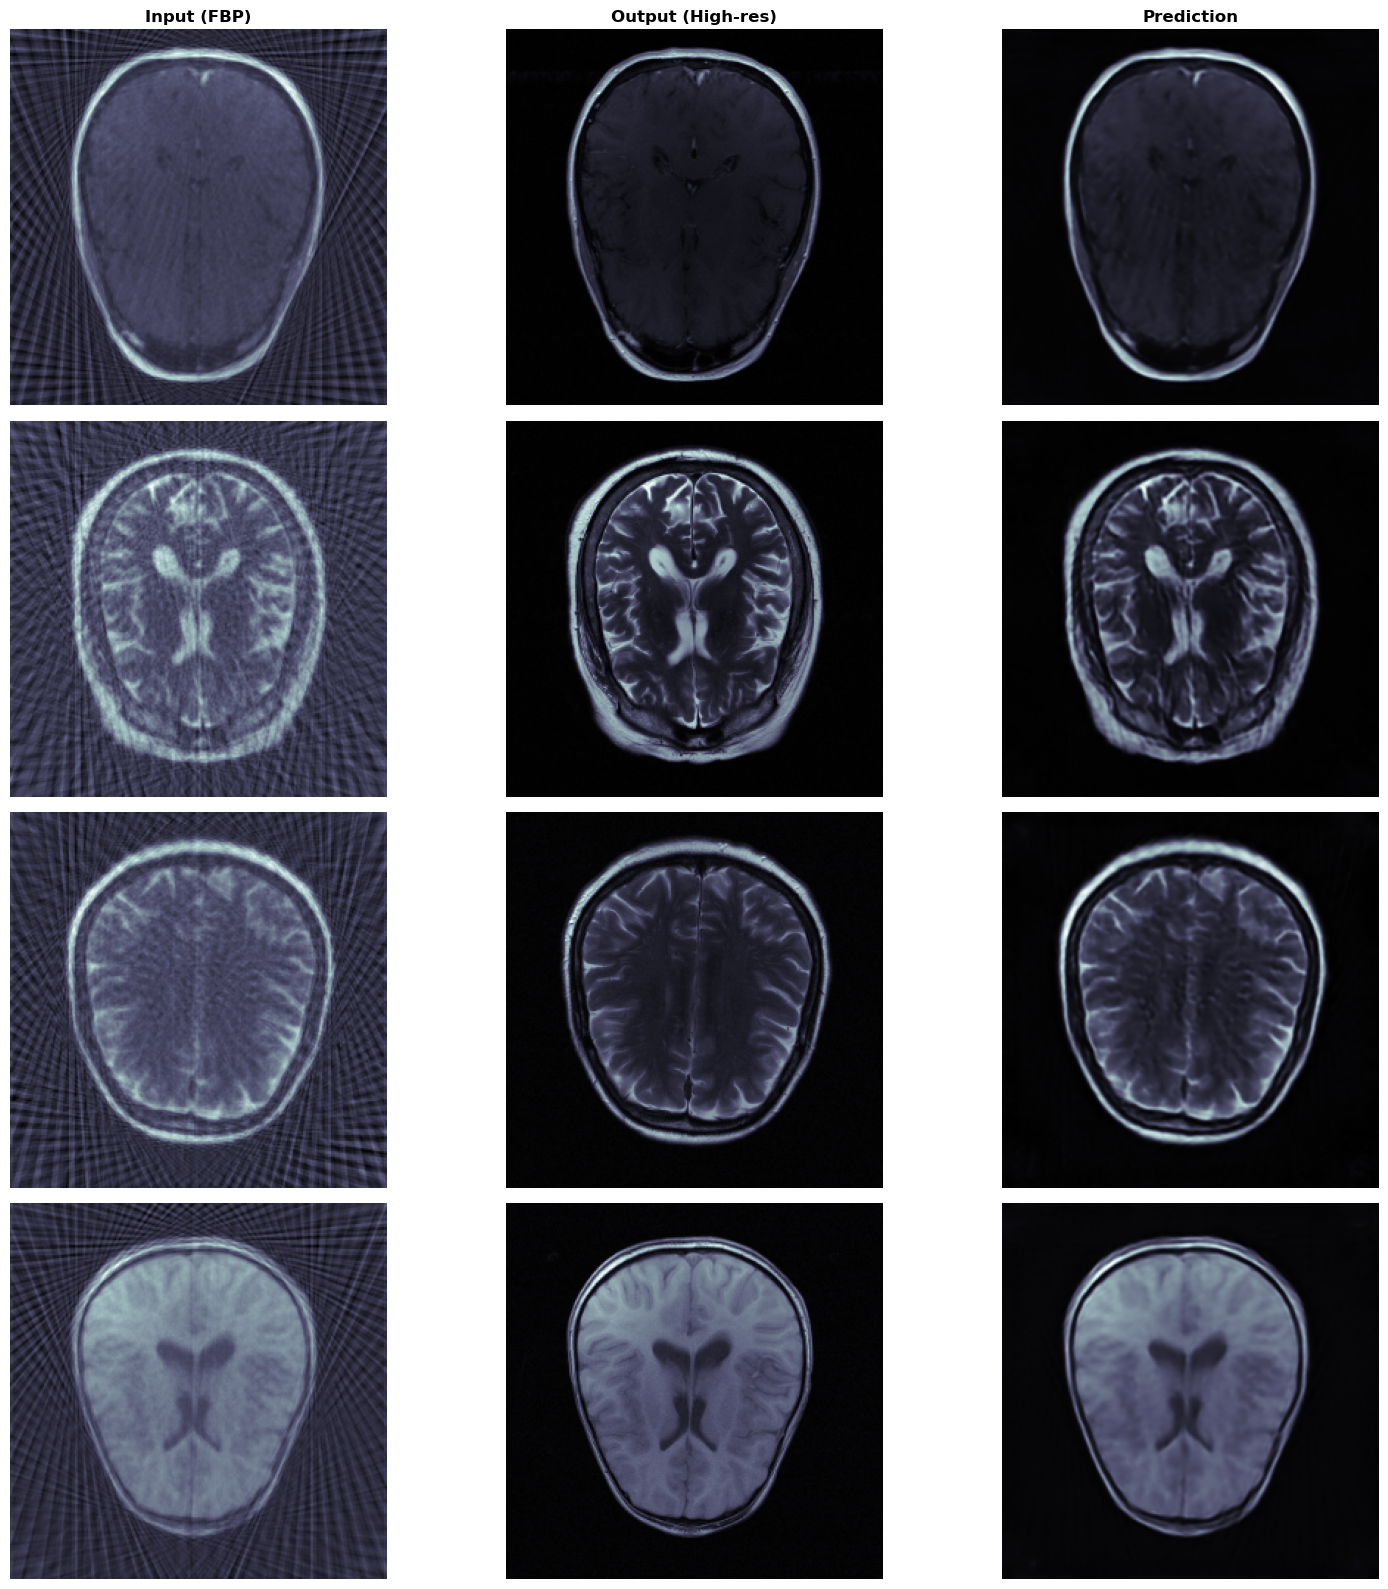

In [10]:
# Validation predictions
Y_valid_pred = network(X_valid[:4].to(device))

fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(16, 16))
for iax, iimage in enumerate(range(4)):
    axs[iax, 0].imshow(X_valid[iimage].squeeze(), cmap="bone")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(Y_valid[iimage].squeeze(), cmap="bone")
    axs[iax, 1].axis("off")
    axs[iax, 2].imshow(Y_valid_pred[iimage].cpu().detach().numpy().squeeze(), cmap="bone")
    axs[iax, 2].axis("off")
axs[0, 0].set_title("Input (FBP)", fontweight="bold")
axs[0, 1].set_title("Output (High-res)", fontweight="bold")
axs[0, 2].set_title("Prediction", fontweight="bold")

plt.tight_layout()

/home/ravasim/Documents/2023/Teaching/DA_summerschool_2023/notebooks/plotting.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


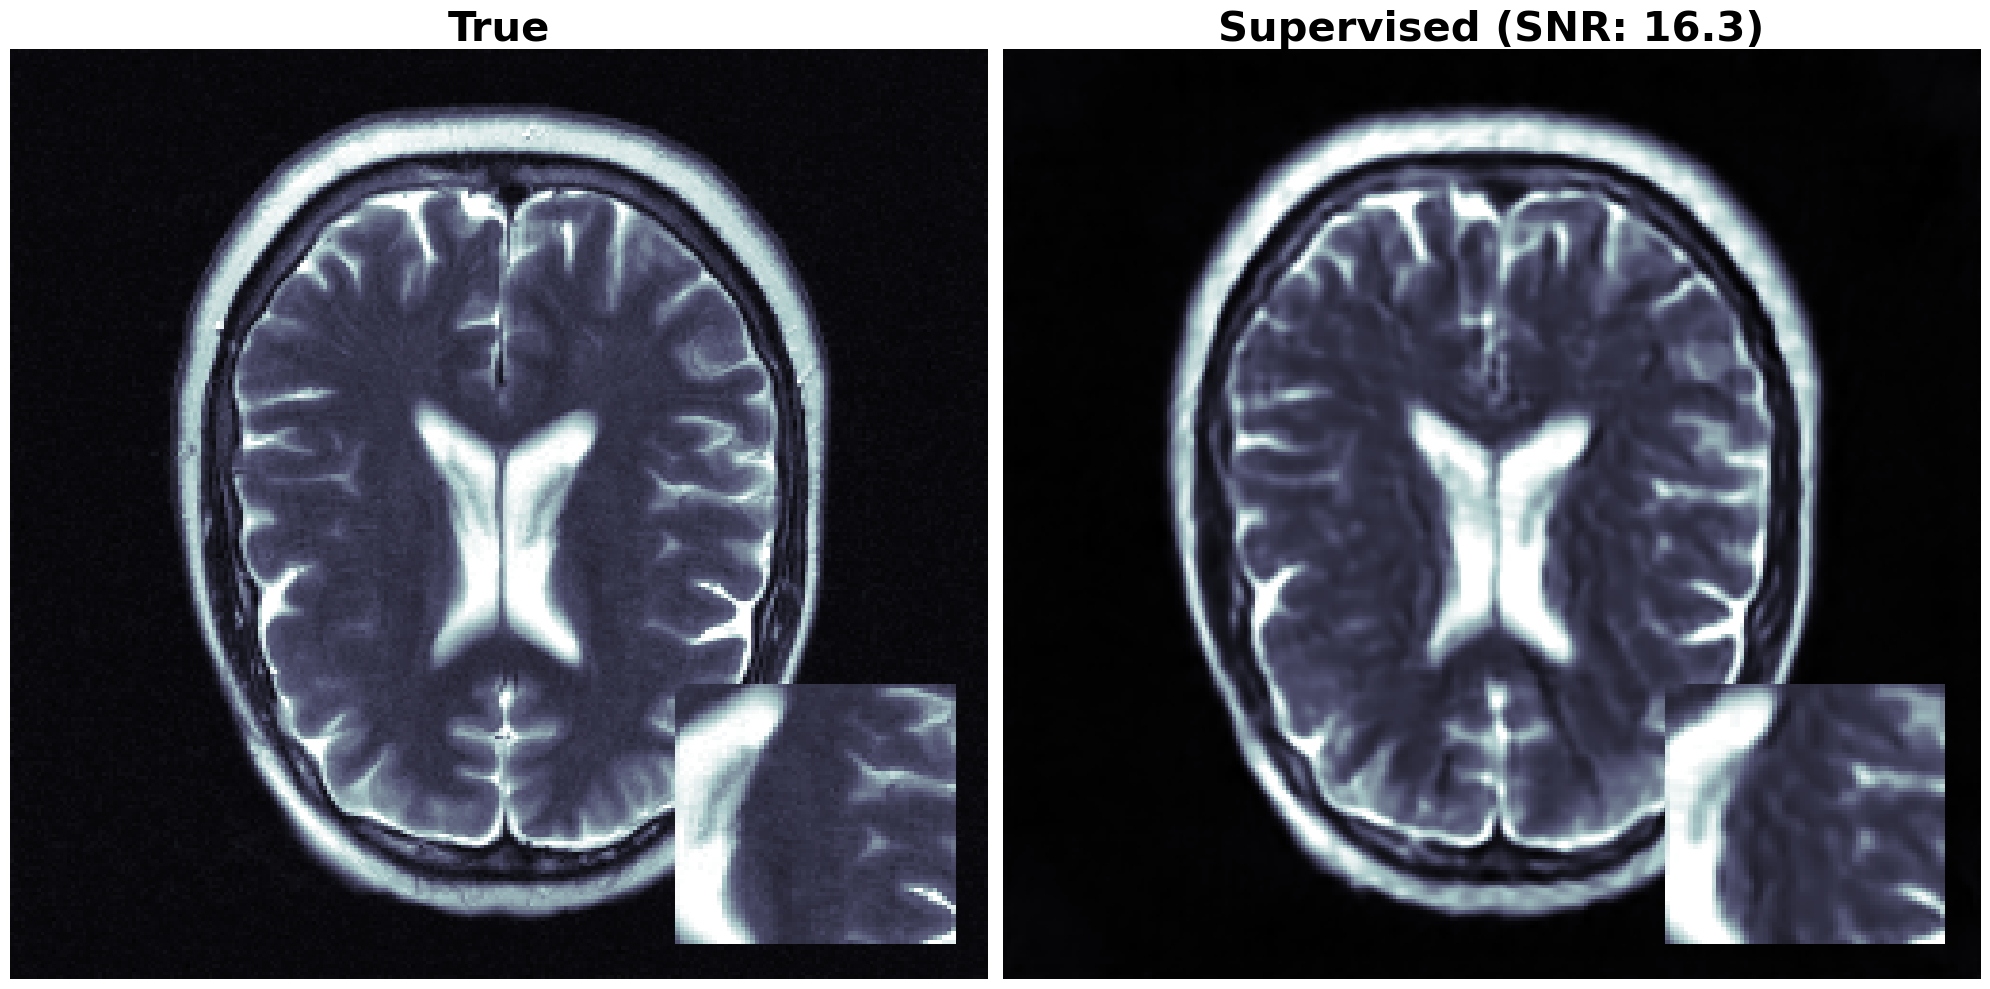

In [11]:
# Test prediction
brain_testpred = network(torch.from_numpy(brainfbp_test).unsqueeze(0).unsqueeze(0).to(device)).squeeze()
brain_testpred -= brain_testpred.min()
brain_testpred /= brain_testpred.max()

plt_comparison(brain_test, brain_testpred.cpu().detach().numpy(), cmap='bone', clim=(0, 0.7), 
               titles=['True', 'Supervised'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)